### Installing packages
You will need to run this code to install some packages.

In [ ]:
!apt-get install xvfb &> /dev/null
!pip install xvfbwrapper &> /dev/null
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install slycot &> /dev/null
!pip install control &> /dev/null


In [ ]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from matplotlib import animation, rc
from IPython.display import HTML

display = Display(visible=0, size=(400, 300))
display.start()

from numpy import cos, sin
from control.matlab import * # this has control.matlab.lqr in it
import os


import numpy as np
import numpy.linalg as la
import scipy

from scipy import integrate
from scipy.linalg import expm
from numpy import vectorize
import control

## System: Inverted Pendulum
The task will be to find the state space model for the system given by the following two equations of motion:
\begin{align*}
(LM-m\ell \cos^2(\theta))\ddot{x}+m\ell g \cos(\theta)\sin(\theta)-Lm\ell \sin(\theta)\dot{\theta}^2&=Lu_1\\
(LM-m\ell \cos^2(\theta))\ddot{\theta}-Mg\sin(\theta)+\frac{Mm\ell}{L}\dot{\theta}^2\cos(\theta)\sin(\theta)&=-\cos(\theta)u_2
\end{align*}
where 
\begin{align*}
u_1&=K_1u + K_2\dot{x}\\
u_2&=K_1u - K_2\dot{x}
\end{align*}
with $K_1$ and $K_2$ defined in the code block below.

### **Parts a and b**
**Part a.** Write this in state-space form using $[x, \dot{x}, \theta, \dot{\theta}]$.

$$\text{let}\ \begin{bmatrix}x\\ \dot{x}\\ \theta\\ \dot{\theta}\end{bmatrix} = \begin{bmatrix}x_1\\ x_2\\ x_3\\ x_4
\end{bmatrix}$$

Then the equations can be re-written in the form of the above variable as:
\begin{align*}
(LM-m\ell \cos^2(x_3))\dot{x_2}+m\ell g \cos(x_3)\sin(x_3)-Lm\ell \sin(x_3)x_4^2&=L(K_1u + K_2x_2)\\
(LM-m\ell \cos^2(x_3))\dot{x_4}-Mg\sin(x_3)+\frac{Mm\ell}{L}x_4^2\cos(x_3)\sin(x_3)&=-\cos(x_3)(K_1u - K_2x_2)
\end{align*}

Thus the statespace representation of the above dynamics becomes:-
$$\begin{bmatrix}\dot{x_1}\\ \dot{x_2}\\ \dot{x_3}\\ \dot{x_4}
\end{bmatrix} = \begin{bmatrix}x_2\\ (L(K_1u + K_2x_2) + Lm\ell \sin(x_3)x_4^2 - m\ell g \cos(x_3)\sin(x_3))\frac{1}{(LM-m\ell \cos^2(x_3))}\\ x_4\\ (Mg\sin(x_3) - \frac{Mm\ell}{L}x_4^2\cos(x_3)\sin(x_3) - \cos(x_3)(K_1u - K_2x_2))\frac{1}{(LM-m\ell \cos^2(x_3))}\end{bmatrix}$$
**Part b.** Fill in the dynam() function in the pendulum class below. 



## Pendulum Class

In [ ]:
from scipy._lib.six import u
class Pendulum(object):
    def __init__(self, dt, init_conds, end, K, m=None, M=None, 
                    l=None,
                    Vsat=None, r=None, R=None, Km=None, Kg=None,
                    lb=None):
        self.dt   = dt
        self.t    = 0.0
        self.x    = init_conds[:]
        self.end  = end
        self.Vsat = Vsat
        self.lb  = lb # bounds for 

        self.m  = m # mass of cart
        self.l  = l # length of pendulum arm
        self.g  = 9.81 # gravity
        self.I  = 0.006 # moment of inertia
        self.r  = r # drive radius
        self.M  = M # mass of pendulum and cart
        self.K  = K # LQR linearized controller
        self.Km = Km # motor torque constant
        self.Kg = Kg # gear ratio
        self.R  = R # armiture resistence
        self.K1 = self.Km*self.Kg/(self.R*self.r)
        self.K2 = self.Km**2*self.Kg**2/(self.R*self.r**2)
        self.theta=[]
        self.L = (self.I + m*l**2)/(m*l)

    def _cmp(self, a,b):
        if a>b:
            return 1
        elif np.allclose(a,b, rtol=1e-6):
            return 0
        else:
            return -1

    def _constrain(self,theta):
        '''
            maps theta into the constraint set
        '''
        theta = theta % (2*np.pi) # mod 2pi
        if theta > np.pi:
            theta = -2*np.pi+theta
        return theta

    def _sat(self, V):
        '''
            Function to compute saturated input
        '''
        if abs(V) > self.Vsat:
            if V>0:
                return self.Vsat
            elif V==0:
                return 0*self.Vsat
            else:
                return -self.Vsat
        return V

    def _average(self,x_):
        '''
            averaging for runge kutta
        '''
        x_i, k1, k2, k3, k4 = x_
        return x_i + (k1 + 2.0*(k3 + k4) +  k2) / 6.0
    
    def dynam(self, x_):
        '''
         Function defining the dynamics. 
         x_ : array with each of the states in it.

         Fill in the code for the nonlinear dynamics
        '''
        x1, x2, x3, x4 = x_
        V = self._sat(self.control(x_))

        # Nolinear Dynamics
        dx1 = x2
        dx2 = (L*K1*V - L*K2*x2 + L*m*l*sin(x3)*x4**2 - m*l*g*sin(x3)*cos(x3))/(L*M - m*l**2*cos(x3))
        dx3 = x4
        dx4 = (M*g*sin(x3) - (M*m*l*x4**2*cos(x3)*sin(x3)/L) - cos(x3)*(K1*V + K2*x2))/(L*M - m*l**2*cos(x3))

        return [dx1, dx2, dx3, dx4]

    def control(self, x_):
        '''
            create the controller
            below the constraint has been applied to the component of 
            x corresponding to theta.
            use this to design a controller that applies the linear feeback
            LQR controller when in +/-20 of theta=0 and other wise applies the
            swing up controller.
        '''
        theta_ = self._constrain(x_[2]) # map theta to constraint set
        if theta_>-np.pi/5 and theta_<np.pi/5:
            ''' do stabilizing controller
                you design this 
            '''
            return float(-self.K@np.array(x_[0:2]+[theta_]+[x_[3]]).T)
        else:
            ''' do swing controller
            '''
            return self.swing_up(x_)
        

    def swing_up(self, x_):
        E0 = 0.
        k = 1
        w = (self.m*self.g*self.l/(4*self.I))**(.5)
        E = self.m*self.g*self.l*(.5*(x_[3]/w)**2 + np.cos(x_[2])-1)
        a = k*(E-E0)*self._cmp(x_[3]*np.cos(x_[2]), 0)
        F = self.M*a # force
        u = (F - self.K2*self._constrain(x_[2]))/self.K1
        return self._sat(u)

    def rk4_step(self, dt):
        '''
            runge kutta solver
        '''
        dx = self.dynam(self.x)
        k2 = [ dx_i*dt for dx_i in dx ]

        xv = [x_i + delx0_i/2.0 for x_i, delx0_i in zip(self.x, k2)]
        k3 = [ dx_i*dt for dx_i in self.dynam(xv)]

        xv = [x_i + delx1_i/2.0 for x_i,delx1_i in zip(self.x, k3)]
        k4 = [ dx_i*dt for dx_i in self.dynam(xv) ]

        xv = [x_i + delx1_2 for x_i,delx1_2 in zip(self.x, k4)]
        k1 = [self.dt*i for i in self.dynam(xv)]
        #self.x = self.x+k2
        self.t += dt
        self.x = list(map(self._average, zip(self.x, k1, k2, k3, k4)))
        self.theta.append(self._constrain(self.x[2]))


    def integrate(self):
        '''
            integration
        '''
        _x = []
        while self.t <= self.end:
            self.rk4_step(self.dt)
            _x.append([self.t] + self.x)
        return np.array(_x)

### **Parts c and d**
**Part c.** Linearize the equations about the vertically upward equillibrium position, $\theta= 0$. Suppose that the system stays within a small neighborhood of this equillbrium. This assumption should be reasonably valid since under control we desire that the pendulum not deviate more than 20 degrees from the vertically upward position.  Let $\phi$ be the deviation of the pendulum's position from equilibrium, i.e., $\theta=\pi+\phi$. Under the assumption that the deviation is small, we can use the small angle approximations of the nonlinear functions:
\begin{align*}
\cos(\theta) & =\cos(\pi+\phi)\simeq -1\\
\sin(\theta) & = \sin(\pi+\phi)\simeq -\phi\\
\dot{\theta}^2&=\dot{\phi}^2\simeq 0
\end{align*}
Use this in computing the linearization.

**Part d.** Fill in the linearized dynamics in the code block below for $A$ and $B$. 

In [ ]:
M = .6  # mass of cart+pendulum
m = .3  # mass of pendulum
Km = 2  # motor torque constant
Kg = .01  # gear ratio

R = 6  # armiture resistance
r = .01  # drive radiu3
K1 = Km*Kg/(R*r)
K2 = Km**2*Kg**2/(R*r**2)
l = .3  # length of pendulum to CG
I = 0.006  # inertia of the pendulum
L = (I + m*l**2)/(m*l)
g = 9.81  # gravity
Vsat = 20.  # saturation voltage



## Fill these in
A = np.array([[0, 1, 0, 0],
             [0, -L*K2/(L*M - m* l), -m*l*g/(L*M - m* l), 0],
             [0, 0, 0, 1],
             [0, K2/(L*M - m*l), M*g /(L*M - m*l), 0]])


B = np.array([[0],[L*K1/(L*M - m*l)], [0],[-K1/(L*M - m*l)] ])

print("Linearized Dynamics:\n Matrix A\n\n", A)
print("\n\nInput Effects on State Dynamics: \n Matrix B:\n\n", B)


Linearized Dynamics:
 Matrix A

 [[ 0.          1.          0.          0.        ]
 [ 0.         -1.88034188 -6.79153846  0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          5.12820513 45.27692308  0.        ]]


Input Effects on State Dynamics: 
 Matrix B:

 [[ 0.        ]
 [ 0.94017094]
 [ 0.        ]
 [-2.56410256]]


### **Part e.**
Assume we can observe $x$ and $\theta$
**Part e.** Using a positive semidefinite $Q$ and $R=6$, find an infinite horizon LQR solution for the linearized dynamics. You will do this two ways.
- **e.1.**   Implement dynamic programing to find $K$: hint solve the matrix Riccati differential equations for large $T$. This is essentially like solving for the discrete case with small step size in the discrete approximation. As you run the algorithm, store the norm error between iterates $\|P_t-P_{t-1}\|^2$. Pass in as an argument to your dp function a tolerance vaule $\epsilon$ and when $\|P_t-P_{t-1}\|^2\leq \epsilon$ print the current iteration and the error value. Store the errors as you go and plot them. 

- **e.2.**   Implement the continuous time version of Hewer's algorithm (you can find it [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1098829), I also posted it on canvas in case you are having trouble access the UW library resources.) 

- **e.3.** Compute the solution via the control toolbox and demonstrate that methods 1 and 2 actually give you the same solution. Provide analysis of the 
solutions (i.e., compare them). What does the convergence rate of Hewer's algorithm 
look like compared to the DP solution?

 To do these comparisions we are going compute two errors as we run the two algorithms. You will need to pass into each of the algorithms an error tolerance $\epsilon=1e$-$2$ and the optimal controller $P^\ast$ as computed by `control.matlab.lqr`. See [here](https://python-control.readthedocs.io/en/latest/generated/control.matlab.lqr.html) for the man pages for this function so you can determine which output is the solution to the Ricatti equation. 

As you run each of the algorithms, store the norm error between iterates $\|P_t-P_{t-1}\|^2$. As you run the algorithm check when $\|P_t-P_{t-1}\|^2\leq \epsilon$ print the current iteration and the error value. Store the errors as you go. 

Store also the error $\|P_t-P^\ast\|^2$ and similarly print when $\|P_t-P^\ast\|^2\leq \epsilon$.

Return both the error sequences and plot them for both methods. Compare the rates at when they converge. 


My suggestion is to start with $Q$ diagonal with much higher weights on the position variables.





In [ ]:
'''
Insert you code here for the LQR solvers. 
'''
## This is an example of a Q you might try
Q = np.array([
    [10000.0, 0.0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 10000, 0],
    [0, 0, 0, 1]
])

## LQR with control.matlab
K_lqr, P_lqr, _ = control.lqr(A, B, Q, R)

### Dynamic programming function
def dp_Riccati(A, B, Q, R, max_iter=1000, epsilon = 1e-6, dt = 1e-2,pstar=P_lqr):
    
    error = []
    error_opt = []
    flag_iter = 0
    flag_opt = 0

    if type(R)== int or type(R) == float:
      R = np.asarray([[R]])

    P_t = np.copy(Q)
    R_inv = la.inv(R)

    for i in range(max_iter):
      M_t = A.T@ P_t + P_t @ A - P_t @ B @ R_inv @ B.T @ P_t + Q
      P_0 = np.copy(P_t)

      P_t = P_t + dt * M_t

      error.append(la.norm(P_t - P_0))
      error_opt.append(la.norm(P_0 - pstar))

      if error[i] <= epsilon and not(flag_iter):
        flag_iter = 1
        print("Error:- ",error[i], "Hits Tolerance at:-", i)  
      
      if error_opt[i] <= epsilon and not(flag_opt):
        flag_opt = 1
        print("Error_opt:-", error_opt[i], "Hits Tolerance at:-", i)
    
    K = R_inv @ B.T @ P_t

    return K, error, error_opt

## Hewer's algorithm function
def Hewer(A, B, Q, R, L0, max_iter= 1000, epsilon=1e-6, pstar=P_lqr):
    
    error = []
    error_opt = []
    flag_iter = 0
    flag_opt = 0

    if type(R)== int or type(R) == float:
      R = np.asarray([[R]])

    R_inv = la.inv(R)
    
    A_0 = A - B @ L0
    V_0 = scipy.linalg.solve_lyapunov(A_0.T, -Q - L0.T @ R @ L0)

    for i in range(max_iter):
      
      L_k = R_inv @ B.T @ V_0
      A_k = A - B @ L_k

      V_k = scipy.linalg.solve_lyapunov(A_k.T, -Q - L_k.T @ R @ L_k)

      dv = V_k - V_0

      V_0 = np.copy(V_k)

      error.append(la.norm(dv))
      error_opt.append(la.norm(V_0 - pstar))

      if error[i] <= epsilon and not(flag_iter):
        flag_iter = 1
        print("Error:- ",error[i], "Hits Tolerance at:-", i)  
      
      if error_opt[i] <= epsilon and not(flag_opt):
        flag_opt = 1
        print("Error_opt:-", error_opt[i], "Hits Tolerance at:-", i)


    K = R_inv @ B.T @ V_k
    return K, error, error_opt


In [ ]:
MAXITER= 1000
## Compute the K's via each method
# name the errors err_dp, err_he, err_dp_opt, err_he_opt so that the plots below work
L_0 = control.place(A, B, [-7, -1, -0.5, -2])
print("Hewer Outputs:")
K_he, err_he, err_he_opt = Hewer(A, B, Q, R, L_0, MAXITER)

# DP
print("\n DP outputs")
K_dp, err_dp, err_dp_opt = dp_Riccati(A, B, Q, R, MAXITER)

Hewer Outputs:
Error_opt:- 2.692201182445273e-07 Hits Tolerance at:- 11
Error:-  1.0914279844860918e-10 Hits Tolerance at:- 12

 DP outputs
Error:-  9.775000579265694e-07 Hits Tolerance at:- 446
Error_opt:- 9.892103872917688e-07 Hits Tolerance at:- 516


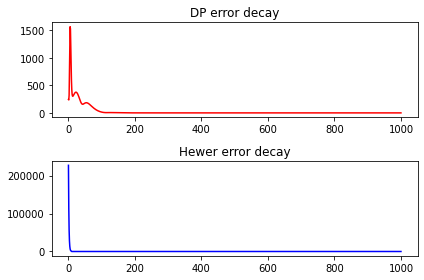

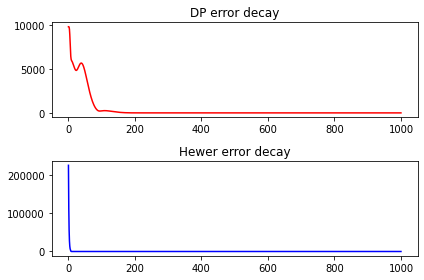

In [ ]:

plt.subplot(211)
plt.plot(list(range(1,MAXITER+1)),err_dp, 'r')
plt.title('DP error decay')
plt.subplot(212)
plt.title('Hewer error decay')
plt.plot(list(range(1,MAXITER+1)),err_he, 'b')
plt.tight_layout()
plt.show()
plt.figure()
plt.subplot(211)
plt.plot(list(range(1,MAXITER+1)),err_dp_opt, 'r')
plt.title('DP error decay')
plt.subplot(212)
plt.title('Hewer error decay')
plt.plot(list(range(1,MAXITER+1)),err_he_opt, 'b')
plt.tight_layout()
plt.show()

Explain what you observe in the plots

## Applying the linearized optimal controller to the Pendulum

In [ ]:
## Call the pendulum class with the appropriate parameters

pendulum = Pendulum(
    .001,
    [-1, 0., 1, 0.],
    10, K_he, m=0.3, M=0.7,
    l=0.3, Vsat=20, r=0.01, 
    R=6, Km=2, Kg=0.01, lb=np.pi/5
)

# integrate
data = pendulum.integrate()
fig = plt.figure(0)
fig.suptitle("Pendulum on Cart", fontsize=14)


cart_time_line = plt.subplot2grid(
    (12, 12),
    (9, 0),
    colspan=12,
    rowspan=3
)
cart_time_line.axis([
    0,
    10,
    min(data[:,1])*1.5,
    max(data[:,1])*1.5+.1,
])
cart_time_line.set_xlabel('time (s)')
cart_time_line.set_ylabel('x (m)')
cart_time_line.plot(data[:,0], data[:,1],'r-')

pendulum_time_line = cart_time_line.twinx()
pendulum_time_line.axis([
    0,
    10,
    min(data[:,3])*1.5-.1,
    max(data[:,3])*1.5
])
pendulum_time_line.set_ylabel('theta (rad)')
pendulum_time_line.plot(data[:,0], data[:,3],'c-')

cart_plot = plt.subplot2grid(
    (12,12),
    (0,0),
    rowspan=8,
    colspan=12
)
cart_plot.axes.get_yaxis().set_visible(False)

plt.close() #FuncAnimation makes another figure

fps = 25
# 5 for constructing the animation quickly
# 25 for smooth animation

#initialize components that will be animated
time_bar, = cart_time_line.plot([0,0], [10, -10], lw=3)
cart_bar, = cart_plot.plot([], [], 'r-', lw=5)
pole_bar, = cart_plot.plot([], [], 'c-', lw=4)

#parameters for FuncAnimation
frame_interval = int(1/fps*1000) #ms
tstop = data[-1][0]
number_frames = int(tstop*fps)

def init():
  time_bar.set_data([], [])
  cart_bar.set_data([], [])
  pole_bar.set_data([], [])
  cart_plot.axis([-1.5,.1,-.5,.5])
  return (time_bar,cart_bar, pole_bar)

def animate(i):
  ind = int(i*frame_interval)
  point = data[ind]
  t = point[0]
  y = [-10, 10]
  time_bar.set_data([t, t], y)

  cart_x = [point[1]-.1,point[1]+.1]
  pole_x = [point[1],point[1]+.4*np.sin(point[3])]
  pole_y = [0,.4*np.cos(point[3])]

  cart_bar.set_data(cart_x, [0, 0])
  pole_bar.set_data(pole_x, pole_y)
  
  return (time_bar,cart_bar, pole_bar)

anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=number_frames, interval=frame_interval, blit=True)

rc('animation', html='jshtml')
anim



In [17]:
''' Running this code will generate a mp4 video which you can watch. Upload the videos with
    your solution.
'''

out_file = os.path.join('/home','/aman','/GIT')
anim.save('Hewer.mp4')

0.8775825618903728